# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

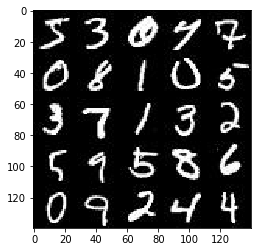

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

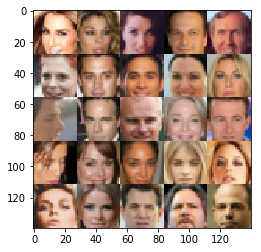

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # First convolutional layer - 14x14x32
        conv_layer = tf.layers.conv2d(images, 32, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Second convolutional layer - 7x764
        conv_layer = tf.layers.conv2d(conv_layer, 64, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=True)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Third convolutional layer - 4x4x128
        conv_layer = tf.layers.conv2d(conv_layer, 128, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=True)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Output
        flat = tf.reshape(conv_layer, (-1, 4 * 4 * 128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected layer
        fc = tf.layers.dense(z, 4 * 4 * 128)
        
        # Reshape
        layer = tf.reshape(fc, (-1, 4, 4, 128))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        
        # First convolutional layer - 7x7x64
        conv_layer = tf.layers.conv2d_transpose(layer, 64, kernel_size=4, strides=1, padding='valid')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=is_train)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Second convolutional layer - 14x14x32
        conv_layer = tf.layers.conv2d_transpose(conv_layer, 32, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=is_train)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Third convolutional layer - 28x28x3
        conv_layer = tf.layers.conv2d_transpose(conv_layer, out_channel_dim, kernel_size=5, strides=2, padding='same')        
        
        # Output
        out = tf.tanh(conv_layer)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
        
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_height, img_width, img_channel = data_shape    
    inputs_real, inputs_z, lr = model_inputs(img_height, img_width, img_channel, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, img_channel, alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Convert the images values from -.5, .5 to -1, 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Run optimizers
                sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                                
                # Show the loss every 10 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print('Epoch: {}/{}'.format(epoch_i + 1, epoch_count),
                          'Discriminator Loss: {}'.format(train_loss_d),
                          'Generator Loss: {}'.format(train_loss_g))
                    
                    # Save the losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # Show the generator ouput every 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2 Discriminator Loss: 0.2500888407230377 Generator Loss: 1.9884153604507446
Epoch: 1/2 Discriminator Loss: 0.16362132132053375 Generator Loss: 2.457068920135498
Epoch: 1/2 Discriminator Loss: 0.10860855132341385 Generator Loss: 2.8877665996551514
Epoch: 1/2 Discriminator Loss: 0.23614974319934845 Generator Loss: 2.0699169635772705
Epoch: 1/2 Discriminator Loss: 0.3294526934623718 Generator Loss: 4.5056562423706055
Epoch: 1/2 Discriminator Loss: 0.6371543407440186 Generator Loss: 0.9938347935676575
Epoch: 1/2 Discriminator Loss: 0.9570563435554504 Generator Loss: 4.7411723136901855
Epoch: 1/2 Discriminator Loss: 0.21862012147903442 Generator Loss: 2.1588165760040283
Epoch: 1/2 Discriminator Loss: 0.22458046674728394 Generator Loss: 2.324638843536377
Epoch: 1/2 Discriminator Loss: 0.20291611552238464 Generator Loss: 2.3879919052124023


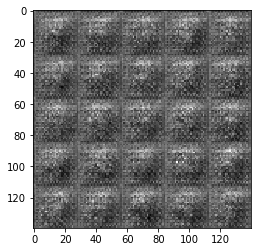

Epoch: 1/2 Discriminator Loss: 0.22086240351200104 Generator Loss: 2.308624267578125
Epoch: 1/2 Discriminator Loss: 0.0961780995130539 Generator Loss: 3.785426616668701
Epoch: 1/2 Discriminator Loss: 0.15963679552078247 Generator Loss: 3.7375152111053467
Epoch: 1/2 Discriminator Loss: 0.17098243534564972 Generator Loss: 2.722904682159424
Epoch: 1/2 Discriminator Loss: 0.12786772847175598 Generator Loss: 3.4712376594543457
Epoch: 1/2 Discriminator Loss: 0.32126420736312866 Generator Loss: 2.256519317626953
Epoch: 1/2 Discriminator Loss: 0.16459912061691284 Generator Loss: 2.9342291355133057
Epoch: 1/2 Discriminator Loss: 0.1315690577030182 Generator Loss: 2.9653894901275635
Epoch: 1/2 Discriminator Loss: 0.16867804527282715 Generator Loss: 2.42393159866333
Epoch: 1/2 Discriminator Loss: 1.4000709056854248 Generator Loss: 7.401742935180664


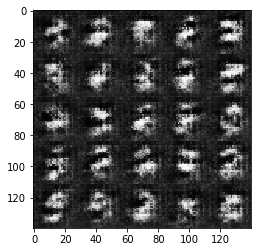

Epoch: 1/2 Discriminator Loss: 0.1867409497499466 Generator Loss: 2.8236019611358643
Epoch: 1/2 Discriminator Loss: 0.41456863284111023 Generator Loss: 1.5137133598327637
Epoch: 1/2 Discriminator Loss: 3.119687795639038 Generator Loss: 8.12077522277832
Epoch: 1/2 Discriminator Loss: 0.7082358002662659 Generator Loss: 0.9733601808547974
Epoch: 1/2 Discriminator Loss: 0.6078758835792542 Generator Loss: 1.0817968845367432
Epoch: 1/2 Discriminator Loss: 0.7475349307060242 Generator Loss: 0.9215518236160278
Epoch: 1/2 Discriminator Loss: 0.28694653511047363 Generator Loss: 2.8626761436462402
Epoch: 1/2 Discriminator Loss: 1.0849920511245728 Generator Loss: 0.547111988067627
Epoch: 1/2 Discriminator Loss: 0.3655252456665039 Generator Loss: 1.989928960800171
Epoch: 1/2 Discriminator Loss: 0.31735432147979736 Generator Loss: 2.388458728790283


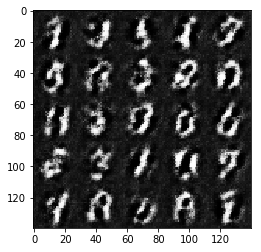

Epoch: 1/2 Discriminator Loss: 1.799866795539856 Generator Loss: 0.2555835247039795
Epoch: 1/2 Discriminator Loss: 0.45018142461776733 Generator Loss: 1.8796191215515137
Epoch: 1/2 Discriminator Loss: 0.3558630049228668 Generator Loss: 2.225304365158081
Epoch: 1/2 Discriminator Loss: 0.5057367086410522 Generator Loss: 1.1379371881484985
Epoch: 1/2 Discriminator Loss: 0.4022546708583832 Generator Loss: 2.7431554794311523
Epoch: 1/2 Discriminator Loss: 0.7844303846359253 Generator Loss: 0.7654864192008972
Epoch: 1/2 Discriminator Loss: 0.38206934928894043 Generator Loss: 1.6112048625946045
Epoch: 1/2 Discriminator Loss: 0.8345767855644226 Generator Loss: 4.749722480773926
Epoch: 1/2 Discriminator Loss: 0.3644968271255493 Generator Loss: 1.8728885650634766
Epoch: 1/2 Discriminator Loss: 0.5404500365257263 Generator Loss: 1.1754823923110962


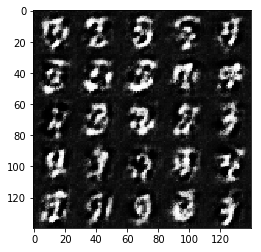

Epoch: 1/2 Discriminator Loss: 0.32941949367523193 Generator Loss: 1.988709807395935
Epoch: 1/2 Discriminator Loss: 0.3758116364479065 Generator Loss: 2.2622809410095215
Epoch: 1/2 Discriminator Loss: 0.3438365161418915 Generator Loss: 2.955824136734009
Epoch: 1/2 Discriminator Loss: 0.33151185512542725 Generator Loss: 1.7415800094604492
Epoch: 1/2 Discriminator Loss: 0.23999086022377014 Generator Loss: 2.256765365600586
Epoch: 1/2 Discriminator Loss: 0.3020792007446289 Generator Loss: 2.831347942352295
Epoch: 1/2 Discriminator Loss: 0.45555219054222107 Generator Loss: 1.6938530206680298
Epoch: 1/2 Discriminator Loss: 0.3126731216907501 Generator Loss: 2.1121432781219482
Epoch: 1/2 Discriminator Loss: 0.35324105620384216 Generator Loss: 1.985215663909912
Epoch: 1/2 Discriminator Loss: 0.33158576488494873 Generator Loss: 1.8282907009124756


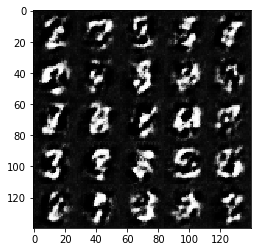

Epoch: 1/2 Discriminator Loss: 0.9939500093460083 Generator Loss: 4.186391830444336
Epoch: 1/2 Discriminator Loss: 0.39040055871009827 Generator Loss: 1.6779980659484863
Epoch: 1/2 Discriminator Loss: 0.33587566018104553 Generator Loss: 2.407073497772217
Epoch: 1/2 Discriminator Loss: 0.2534528374671936 Generator Loss: 2.4708123207092285
Epoch: 1/2 Discriminator Loss: 0.7935882210731506 Generator Loss: 0.7601109743118286
Epoch: 1/2 Discriminator Loss: 0.4073023796081543 Generator Loss: 2.4211461544036865
Epoch: 1/2 Discriminator Loss: 1.5125528573989868 Generator Loss: 0.32609426975250244
Epoch: 1/2 Discriminator Loss: 0.316867470741272 Generator Loss: 2.178041458129883
Epoch: 1/2 Discriminator Loss: 0.34590741991996765 Generator Loss: 2.213921546936035
Epoch: 1/2 Discriminator Loss: 0.29178163409233093 Generator Loss: 2.3199679851531982


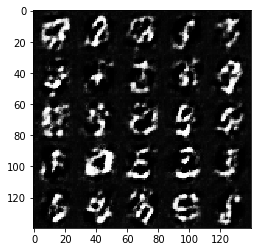

Epoch: 1/2 Discriminator Loss: 0.30825966596603394 Generator Loss: 2.1595969200134277
Epoch: 1/2 Discriminator Loss: 0.3791015148162842 Generator Loss: 3.28118634223938
Epoch: 1/2 Discriminator Loss: 0.5044382810592651 Generator Loss: 2.504838705062866
Epoch: 1/2 Discriminator Loss: 0.27731287479400635 Generator Loss: 2.290137767791748
Epoch: 1/2 Discriminator Loss: 0.359162837266922 Generator Loss: 1.9861323833465576
Epoch: 1/2 Discriminator Loss: 0.8644492030143738 Generator Loss: 0.7251718640327454
Epoch: 1/2 Discriminator Loss: 0.27745646238327026 Generator Loss: 2.3588132858276367
Epoch: 1/2 Discriminator Loss: 1.7660374641418457 Generator Loss: 0.2679838538169861
Epoch: 1/2 Discriminator Loss: 0.29621410369873047 Generator Loss: 2.1993231773376465
Epoch: 1/2 Discriminator Loss: 0.31033194065093994 Generator Loss: 2.332650661468506


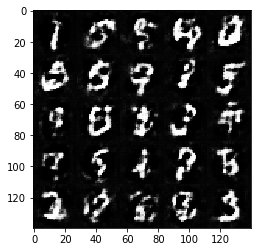

Epoch: 1/2 Discriminator Loss: 2.255276679992676 Generator Loss: 0.17760133743286133
Epoch: 1/2 Discriminator Loss: 0.3211979866027832 Generator Loss: 1.879615306854248
Epoch: 1/2 Discriminator Loss: 0.3796253800392151 Generator Loss: 1.8469676971435547
Epoch: 1/2 Discriminator Loss: 0.27982422709465027 Generator Loss: 1.9800901412963867
Epoch: 1/2 Discriminator Loss: 0.3502090573310852 Generator Loss: 2.708580493927002
Epoch: 1/2 Discriminator Loss: 0.5325832962989807 Generator Loss: 1.0759897232055664
Epoch: 1/2 Discriminator Loss: 0.3644890785217285 Generator Loss: 2.00587797164917
Epoch: 1/2 Discriminator Loss: 1.106776237487793 Generator Loss: 4.311565399169922
Epoch: 1/2 Discriminator Loss: 0.3914012908935547 Generator Loss: 1.7122344970703125
Epoch: 1/2 Discriminator Loss: 0.360456258058548 Generator Loss: 1.7767764329910278


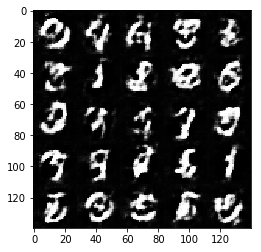

Epoch: 1/2 Discriminator Loss: 0.5380995273590088 Generator Loss: 3.0930137634277344
Epoch: 1/2 Discriminator Loss: 0.26764875650405884 Generator Loss: 2.361909866333008
Epoch: 1/2 Discriminator Loss: 0.2522267699241638 Generator Loss: 2.4423789978027344
Epoch: 1/2 Discriminator Loss: 0.35099416971206665 Generator Loss: 2.1008763313293457
Epoch: 1/2 Discriminator Loss: 0.27055126428604126 Generator Loss: 2.561591386795044
Epoch: 1/2 Discriminator Loss: 0.5314551591873169 Generator Loss: 1.3702621459960938
Epoch: 1/2 Discriminator Loss: 0.8654850125312805 Generator Loss: 3.5724430084228516
Epoch: 1/2 Discriminator Loss: 0.33457469940185547 Generator Loss: 1.8423964977264404
Epoch: 1/2 Discriminator Loss: 0.4725598692893982 Generator Loss: 1.4184074401855469
Epoch: 1/2 Discriminator Loss: 0.35564959049224854 Generator Loss: 1.9822406768798828


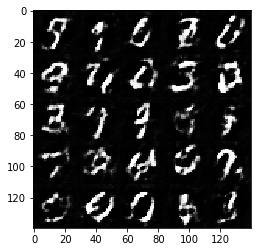

Epoch: 1/2 Discriminator Loss: 0.5325257778167725 Generator Loss: 1.234492301940918
Epoch: 1/2 Discriminator Loss: 0.3116089701652527 Generator Loss: 2.160409450531006
Epoch: 1/2 Discriminator Loss: 0.3622971177101135 Generator Loss: 2.0553605556488037
Epoch: 2/2 Discriminator Loss: 0.5181236863136292 Generator Loss: 1.2414848804473877
Epoch: 2/2 Discriminator Loss: 0.35399508476257324 Generator Loss: 3.444387912750244
Epoch: 2/2 Discriminator Loss: 0.3884393870830536 Generator Loss: 1.7565727233886719
Epoch: 2/2 Discriminator Loss: 0.7726569175720215 Generator Loss: 0.9116328954696655
Epoch: 2/2 Discriminator Loss: 0.5791504383087158 Generator Loss: 1.092928171157837
Epoch: 2/2 Discriminator Loss: 0.41491806507110596 Generator Loss: 1.566874384880066
Epoch: 2/2 Discriminator Loss: 1.109254002571106 Generator Loss: 0.5385259389877319


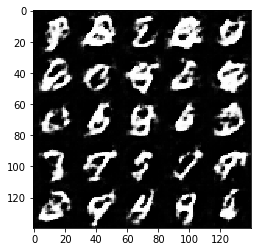

Epoch: 2/2 Discriminator Loss: 0.36196038126945496 Generator Loss: 1.6159892082214355
Epoch: 2/2 Discriminator Loss: 0.2609224021434784 Generator Loss: 2.375814437866211
Epoch: 2/2 Discriminator Loss: 0.4617754817008972 Generator Loss: 1.4365242719650269
Epoch: 2/2 Discriminator Loss: 0.5556142926216125 Generator Loss: 1.9014687538146973
Epoch: 2/2 Discriminator Loss: 0.2816779613494873 Generator Loss: 2.3532721996307373
Epoch: 2/2 Discriminator Loss: 0.3873424828052521 Generator Loss: 1.6716221570968628
Epoch: 2/2 Discriminator Loss: 0.42157915234565735 Generator Loss: 2.041210889816284
Epoch: 2/2 Discriminator Loss: 0.40079402923583984 Generator Loss: 1.9018844366073608
Epoch: 2/2 Discriminator Loss: 0.4578600227832794 Generator Loss: 1.4566857814788818
Epoch: 2/2 Discriminator Loss: 1.2943601608276367 Generator Loss: 0.5043494701385498


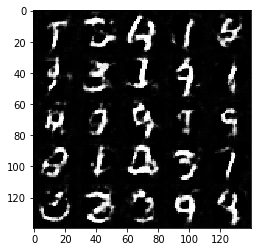

Epoch: 2/2 Discriminator Loss: 0.1991599202156067 Generator Loss: 2.8232083320617676
Epoch: 2/2 Discriminator Loss: 0.33958736062049866 Generator Loss: 2.5125575065612793
Epoch: 2/2 Discriminator Loss: 0.30766212940216064 Generator Loss: 2.325744390487671
Epoch: 2/2 Discriminator Loss: 0.48126643896102905 Generator Loss: 2.7598419189453125
Epoch: 2/2 Discriminator Loss: 0.4262542426586151 Generator Loss: 1.805179238319397
Epoch: 2/2 Discriminator Loss: 0.5894408226013184 Generator Loss: 1.133784294128418
Epoch: 2/2 Discriminator Loss: 0.3737444579601288 Generator Loss: 2.2734122276306152
Epoch: 2/2 Discriminator Loss: 0.9228094220161438 Generator Loss: 0.7280935049057007
Epoch: 2/2 Discriminator Loss: 0.3183814287185669 Generator Loss: 2.0034003257751465
Epoch: 2/2 Discriminator Loss: 0.323722779750824 Generator Loss: 1.8498135805130005


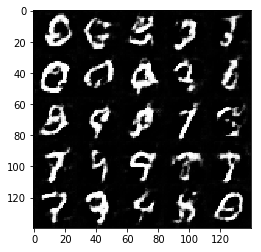

Epoch: 2/2 Discriminator Loss: 0.5125303864479065 Generator Loss: 1.3955949544906616
Epoch: 2/2 Discriminator Loss: 0.8477042317390442 Generator Loss: 3.58278751373291
Epoch: 2/2 Discriminator Loss: 0.6036697030067444 Generator Loss: 1.696141004562378
Epoch: 2/2 Discriminator Loss: 0.49245327711105347 Generator Loss: 1.441906452178955
Epoch: 2/2 Discriminator Loss: 1.110062837600708 Generator Loss: 3.7216901779174805
Epoch: 2/2 Discriminator Loss: 0.5211184024810791 Generator Loss: 1.8681542873382568
Epoch: 2/2 Discriminator Loss: 0.6201777458190918 Generator Loss: 1.0096814632415771
Epoch: 2/2 Discriminator Loss: 0.4326643645763397 Generator Loss: 1.4376869201660156
Epoch: 2/2 Discriminator Loss: 0.4713420569896698 Generator Loss: 1.6583197116851807
Epoch: 2/2 Discriminator Loss: 0.8599536418914795 Generator Loss: 3.5735063552856445


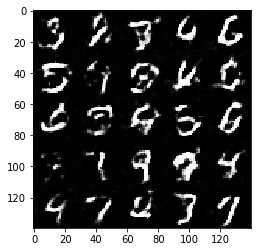

Epoch: 2/2 Discriminator Loss: 0.36625951528549194 Generator Loss: 1.9602912664413452
Epoch: 2/2 Discriminator Loss: 1.8150910139083862 Generator Loss: 4.506662368774414
Epoch: 2/2 Discriminator Loss: 0.3913547992706299 Generator Loss: 2.2535552978515625
Epoch: 2/2 Discriminator Loss: 0.4184015989303589 Generator Loss: 2.157548427581787
Epoch: 2/2 Discriminator Loss: 0.8185031414031982 Generator Loss: 0.9082543253898621
Epoch: 2/2 Discriminator Loss: 0.46486878395080566 Generator Loss: 1.4078307151794434
Epoch: 2/2 Discriminator Loss: 0.41447749733924866 Generator Loss: 2.111238479614258
Epoch: 2/2 Discriminator Loss: 0.35761892795562744 Generator Loss: 1.9178481101989746
Epoch: 2/2 Discriminator Loss: 0.38052642345428467 Generator Loss: 1.8376805782318115
Epoch: 2/2 Discriminator Loss: 2.7016782760620117 Generator Loss: 5.372028350830078


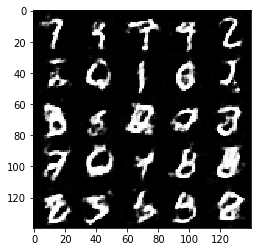

Epoch: 2/2 Discriminator Loss: 0.6383534073829651 Generator Loss: 1.125187635421753
Epoch: 2/2 Discriminator Loss: 0.47102585434913635 Generator Loss: 1.603363275527954
Epoch: 2/2 Discriminator Loss: 0.8986223936080933 Generator Loss: 0.6688978672027588
Epoch: 2/2 Discriminator Loss: 0.3694612383842468 Generator Loss: 1.7011888027191162
Epoch: 2/2 Discriminator Loss: 0.9185819625854492 Generator Loss: 2.8309154510498047
Epoch: 2/2 Discriminator Loss: 0.560369074344635 Generator Loss: 1.2604124546051025
Epoch: 2/2 Discriminator Loss: 0.5203577280044556 Generator Loss: 1.3596969842910767
Epoch: 2/2 Discriminator Loss: 0.4907851815223694 Generator Loss: 2.218615770339966
Epoch: 2/2 Discriminator Loss: 0.5049766302108765 Generator Loss: 1.9723243713378906
Epoch: 2/2 Discriminator Loss: 0.7378448247909546 Generator Loss: 1.3023874759674072


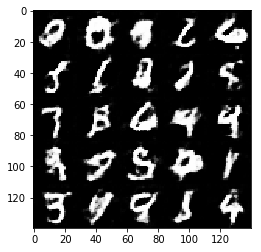

Epoch: 2/2 Discriminator Loss: 0.5996983051300049 Generator Loss: 1.1845085620880127
Epoch: 2/2 Discriminator Loss: 0.45814049243927 Generator Loss: 1.73406982421875
Epoch: 2/2 Discriminator Loss: 0.47172218561172485 Generator Loss: 1.425240397453308
Epoch: 2/2 Discriminator Loss: 0.38785991072654724 Generator Loss: 1.9870002269744873
Epoch: 2/2 Discriminator Loss: 0.5019499063491821 Generator Loss: 1.3062562942504883
Epoch: 2/2 Discriminator Loss: 0.5957427024841309 Generator Loss: 1.1946569681167603
Epoch: 2/2 Discriminator Loss: 0.5114437937736511 Generator Loss: 1.8709722757339478
Epoch: 2/2 Discriminator Loss: 0.7195583581924438 Generator Loss: 0.9309099316596985
Epoch: 2/2 Discriminator Loss: 0.5783860683441162 Generator Loss: 1.4821604490280151
Epoch: 2/2 Discriminator Loss: 1.8495010137557983 Generator Loss: 4.491133689880371


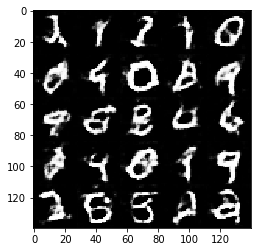

Epoch: 2/2 Discriminator Loss: 0.7374060750007629 Generator Loss: 0.9931274652481079
Epoch: 2/2 Discriminator Loss: 0.6594960689544678 Generator Loss: 1.049393653869629
Epoch: 2/2 Discriminator Loss: 0.8534879088401794 Generator Loss: 0.7440828084945679
Epoch: 2/2 Discriminator Loss: 0.5675738453865051 Generator Loss: 1.2456563711166382
Epoch: 2/2 Discriminator Loss: 0.4169277548789978 Generator Loss: 2.042222023010254
Epoch: 2/2 Discriminator Loss: 0.4850521981716156 Generator Loss: 1.3397042751312256
Epoch: 2/2 Discriminator Loss: 0.4827736020088196 Generator Loss: 1.259493112564087
Epoch: 2/2 Discriminator Loss: 0.48739826679229736 Generator Loss: 1.5048515796661377
Epoch: 2/2 Discriminator Loss: 0.4211040139198303 Generator Loss: 1.5046329498291016
Epoch: 2/2 Discriminator Loss: 0.5443406105041504 Generator Loss: 1.2546775341033936


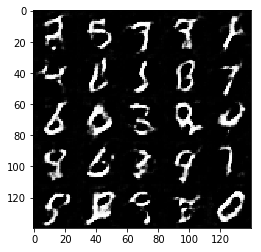

Epoch: 2/2 Discriminator Loss: 0.8422740697860718 Generator Loss: 0.7348136901855469
Epoch: 2/2 Discriminator Loss: 0.4471123516559601 Generator Loss: 1.9817044734954834
Epoch: 2/2 Discriminator Loss: 0.5321717262268066 Generator Loss: 1.3052990436553955
Epoch: 2/2 Discriminator Loss: 0.6468589901924133 Generator Loss: 1.0392448902130127
Epoch: 2/2 Discriminator Loss: 0.45779651403427124 Generator Loss: 2.017225503921509
Epoch: 2/2 Discriminator Loss: 0.3815544843673706 Generator Loss: 1.6250470876693726
Epoch: 2/2 Discriminator Loss: 0.41014182567596436 Generator Loss: 1.6235846281051636
Epoch: 2/2 Discriminator Loss: 1.7587891817092896 Generator Loss: 0.3710763454437256
Epoch: 2/2 Discriminator Loss: 0.3079105019569397 Generator Loss: 2.3400633335113525
Epoch: 2/2 Discriminator Loss: 0.8145813941955566 Generator Loss: 1.3172903060913086


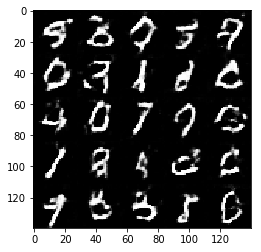

Epoch: 2/2 Discriminator Loss: 0.7388976216316223 Generator Loss: 1.3254203796386719
Epoch: 2/2 Discriminator Loss: 0.7784614562988281 Generator Loss: 0.8427885174751282
Epoch: 2/2 Discriminator Loss: 0.47925928235054016 Generator Loss: 1.7824509143829346
Epoch: 2/2 Discriminator Loss: 0.4797396957874298 Generator Loss: 1.777773380279541
Epoch: 2/2 Discriminator Loss: 0.5554527640342712 Generator Loss: 1.484924554824829
Epoch: 2/2 Discriminator Loss: 0.5740245580673218 Generator Loss: 1.8660736083984375
Epoch: 2/2 Discriminator Loss: 0.46319979429244995 Generator Loss: 1.3976716995239258


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

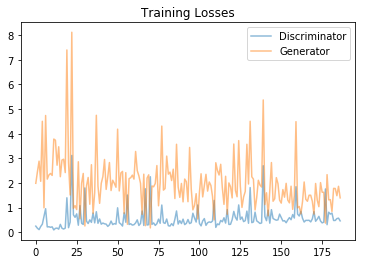

In [13]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1 Discriminator Loss: 0.2834612727165222 Generator Loss: 1.8828305006027222
Epoch: 1/1 Discriminator Loss: 0.17844879627227783 Generator Loss: 2.4194107055664062
Epoch: 1/1 Discriminator Loss: 0.14145708084106445 Generator Loss: 2.843886613845825
Epoch: 1/1 Discriminator Loss: 0.16309136152267456 Generator Loss: 2.418668746948242
Epoch: 1/1 Discriminator Loss: 0.14580342173576355 Generator Loss: 2.775622844696045
Epoch: 1/1 Discriminator Loss: 0.10695052146911621 Generator Loss: 2.8664710521698
Epoch: 1/1 Discriminator Loss: 0.0618797205388546 Generator Loss: 3.6467747688293457
Epoch: 1/1 Discriminator Loss: 0.07977201044559479 Generator Loss: 3.4686131477355957
Epoch: 1/1 Discriminator Loss: 0.05612620338797569 Generator Loss: 3.9363064765930176
Epoch: 1/1 Discriminator Loss: 0.037131473422050476 Generator Loss: 4.4110822677612305


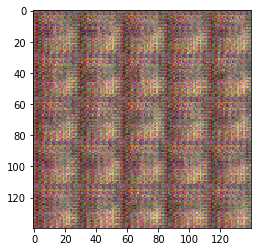

Epoch: 1/1 Discriminator Loss: 0.14495554566383362 Generator Loss: 5.973414421081543
Epoch: 1/1 Discriminator Loss: 0.2167733609676361 Generator Loss: 1.8457510471343994
Epoch: 1/1 Discriminator Loss: 0.138307124376297 Generator Loss: 4.946655750274658
Epoch: 1/1 Discriminator Loss: 0.0845380574464798 Generator Loss: 3.431975841522217
Epoch: 1/1 Discriminator Loss: 0.09675510227680206 Generator Loss: 3.4050068855285645
Epoch: 1/1 Discriminator Loss: 0.10818344354629517 Generator Loss: 3.526020050048828
Epoch: 1/1 Discriminator Loss: 0.08325076103210449 Generator Loss: 4.147272109985352
Epoch: 1/1 Discriminator Loss: 0.11545959860086441 Generator Loss: 3.053429126739502
Epoch: 1/1 Discriminator Loss: 0.10562597215175629 Generator Loss: 3.583223342895508
Epoch: 1/1 Discriminator Loss: 0.06212884187698364 Generator Loss: 4.557475566864014


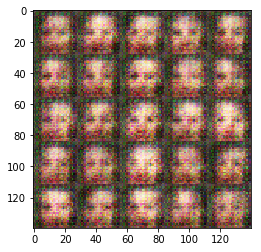

Epoch: 1/1 Discriminator Loss: 0.3617275059223175 Generator Loss: 1.8141610622406006
Epoch: 1/1 Discriminator Loss: 0.14410027861595154 Generator Loss: 3.4271457195281982
Epoch: 1/1 Discriminator Loss: 0.5653649568557739 Generator Loss: 4.028683185577393
Epoch: 1/1 Discriminator Loss: 0.2756648659706116 Generator Loss: 2.463700771331787
Epoch: 1/1 Discriminator Loss: 0.29563355445861816 Generator Loss: 2.7334225177764893
Epoch: 1/1 Discriminator Loss: 0.28584763407707214 Generator Loss: 2.9643192291259766
Epoch: 1/1 Discriminator Loss: 0.2637566924095154 Generator Loss: 2.180208683013916
Epoch: 1/1 Discriminator Loss: 0.11161305010318756 Generator Loss: 3.042921543121338
Epoch: 1/1 Discriminator Loss: 0.2833307385444641 Generator Loss: 4.0162272453308105
Epoch: 1/1 Discriminator Loss: 0.3940315842628479 Generator Loss: 1.705977201461792


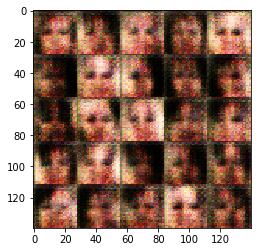

Epoch: 1/1 Discriminator Loss: 0.3321269154548645 Generator Loss: 2.72684907913208
Epoch: 1/1 Discriminator Loss: 0.29627078771591187 Generator Loss: 2.7162299156188965
Epoch: 1/1 Discriminator Loss: 0.21685510873794556 Generator Loss: 2.9018516540527344
Epoch: 1/1 Discriminator Loss: 0.18015533685684204 Generator Loss: 4.464815616607666
Epoch: 1/1 Discriminator Loss: 0.244174063205719 Generator Loss: 2.4506473541259766
Epoch: 1/1 Discriminator Loss: 0.22797393798828125 Generator Loss: 2.939923048019409
Epoch: 1/1 Discriminator Loss: 0.22504489123821259 Generator Loss: 2.616283893585205
Epoch: 1/1 Discriminator Loss: 0.36825671792030334 Generator Loss: 1.6799917221069336
Epoch: 1/1 Discriminator Loss: 0.39194926619529724 Generator Loss: 1.974503993988037
Epoch: 1/1 Discriminator Loss: 0.18954220414161682 Generator Loss: 3.62973690032959


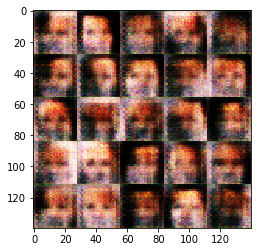

Epoch: 1/1 Discriminator Loss: 0.3246768116950989 Generator Loss: 2.2742679119110107
Epoch: 1/1 Discriminator Loss: 0.23311282694339752 Generator Loss: 2.6223297119140625
Epoch: 1/1 Discriminator Loss: 0.2777630388736725 Generator Loss: 4.460205554962158
Epoch: 1/1 Discriminator Loss: 0.22931930422782898 Generator Loss: 2.708597183227539
Epoch: 1/1 Discriminator Loss: 0.15417857468128204 Generator Loss: 2.961193561553955
Epoch: 1/1 Discriminator Loss: 0.33161503076553345 Generator Loss: 1.8502675294876099
Epoch: 1/1 Discriminator Loss: 0.4376316964626312 Generator Loss: 1.6028392314910889
Epoch: 1/1 Discriminator Loss: 0.1623060405254364 Generator Loss: 4.044896602630615
Epoch: 1/1 Discriminator Loss: 0.2572610676288605 Generator Loss: 2.686551332473755
Epoch: 1/1 Discriminator Loss: 0.23435385525226593 Generator Loss: 2.8066396713256836


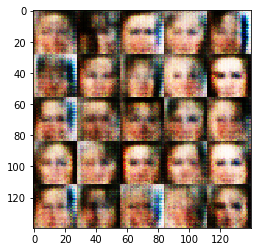

Epoch: 1/1 Discriminator Loss: 0.25711512565612793 Generator Loss: 3.0136871337890625
Epoch: 1/1 Discriminator Loss: 0.38044318556785583 Generator Loss: 2.146148681640625
Epoch: 1/1 Discriminator Loss: 0.444379985332489 Generator Loss: 1.549426555633545
Epoch: 1/1 Discriminator Loss: 0.24366457760334015 Generator Loss: 2.8848791122436523
Epoch: 1/1 Discriminator Loss: 0.45342445373535156 Generator Loss: 1.3733224868774414
Epoch: 1/1 Discriminator Loss: 0.3873561918735504 Generator Loss: 2.2458505630493164
Epoch: 1/1 Discriminator Loss: 0.29177674651145935 Generator Loss: 2.1306018829345703
Epoch: 1/1 Discriminator Loss: 0.31971824169158936 Generator Loss: 1.9972563982009888
Epoch: 1/1 Discriminator Loss: 0.4613649249076843 Generator Loss: 3.7886414527893066
Epoch: 1/1 Discriminator Loss: 0.4059697985649109 Generator Loss: 3.0770418643951416


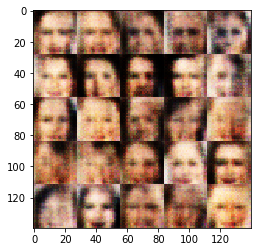

Epoch: 1/1 Discriminator Loss: 0.3149545192718506 Generator Loss: 2.192833423614502
Epoch: 1/1 Discriminator Loss: 0.31296002864837646 Generator Loss: 2.304647922515869
Epoch: 1/1 Discriminator Loss: 0.383518248796463 Generator Loss: 1.686416506767273
Epoch: 1/1 Discriminator Loss: 2.020676374435425 Generator Loss: 7.638014793395996
Epoch: 1/1 Discriminator Loss: 0.28497350215911865 Generator Loss: 2.468003273010254
Epoch: 1/1 Discriminator Loss: 0.4447230100631714 Generator Loss: 2.446650266647339
Epoch: 1/1 Discriminator Loss: 0.2899167537689209 Generator Loss: 2.5442633628845215
Epoch: 1/1 Discriminator Loss: 0.3404960632324219 Generator Loss: 3.1949007511138916
Epoch: 1/1 Discriminator Loss: 0.38725775480270386 Generator Loss: 2.152595043182373
Epoch: 1/1 Discriminator Loss: 0.2754717767238617 Generator Loss: 2.064953088760376


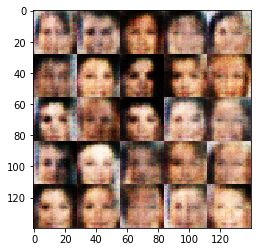

Epoch: 1/1 Discriminator Loss: 0.23853987455368042 Generator Loss: 2.1582560539245605
Epoch: 1/1 Discriminator Loss: 0.5854815244674683 Generator Loss: 1.397796630859375
Epoch: 1/1 Discriminator Loss: 0.3544800281524658 Generator Loss: 2.244821548461914
Epoch: 1/1 Discriminator Loss: 0.5629599690437317 Generator Loss: 1.1944271326065063
Epoch: 1/1 Discriminator Loss: 0.36536985635757446 Generator Loss: 2.0934407711029053
Epoch: 1/1 Discriminator Loss: 0.4152688980102539 Generator Loss: 1.6547995805740356
Epoch: 1/1 Discriminator Loss: 0.36462441086769104 Generator Loss: 2.4912028312683105
Epoch: 1/1 Discriminator Loss: 0.6114546656608582 Generator Loss: 3.4506418704986572
Epoch: 1/1 Discriminator Loss: 0.20639246702194214 Generator Loss: 2.5426974296569824
Epoch: 1/1 Discriminator Loss: 0.4998024106025696 Generator Loss: 2.196889877319336


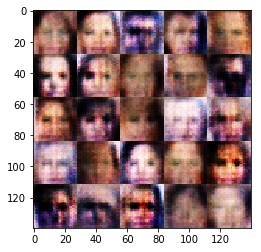

Epoch: 1/1 Discriminator Loss: 0.40982601046562195 Generator Loss: 1.7212505340576172
Epoch: 1/1 Discriminator Loss: 0.528106689453125 Generator Loss: 1.564239740371704
Epoch: 1/1 Discriminator Loss: 0.7732753157615662 Generator Loss: 3.0392298698425293
Epoch: 1/1 Discriminator Loss: 1.6409211158752441 Generator Loss: 0.29819971323013306
Epoch: 1/1 Discriminator Loss: 0.39854001998901367 Generator Loss: 1.8963217735290527
Epoch: 1/1 Discriminator Loss: 0.8146427273750305 Generator Loss: 0.7614701390266418
Epoch: 1/1 Discriminator Loss: 0.5861534476280212 Generator Loss: 2.487734317779541
Epoch: 1/1 Discriminator Loss: 0.48605987429618835 Generator Loss: 1.6622505187988281
Epoch: 1/1 Discriminator Loss: 0.6166684031486511 Generator Loss: 3.331746816635132
Epoch: 1/1 Discriminator Loss: 0.6531771421432495 Generator Loss: 1.0555479526519775


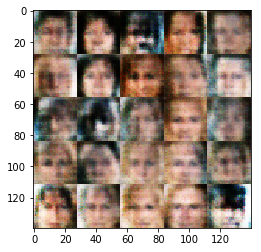

Epoch: 1/1 Discriminator Loss: 0.5152614712715149 Generator Loss: 1.405548334121704
Epoch: 1/1 Discriminator Loss: 0.680801510810852 Generator Loss: 1.091673731803894
Epoch: 1/1 Discriminator Loss: 0.3999536633491516 Generator Loss: 2.6306886672973633
Epoch: 1/1 Discriminator Loss: 0.30853942036628723 Generator Loss: 2.389443874359131
Epoch: 1/1 Discriminator Loss: 0.47951003909111023 Generator Loss: 1.7582354545593262
Epoch: 1/1 Discriminator Loss: 0.6875218749046326 Generator Loss: 1.1530461311340332
Epoch: 1/1 Discriminator Loss: 0.8197147846221924 Generator Loss: 0.9813672304153442
Epoch: 1/1 Discriminator Loss: 0.3912925124168396 Generator Loss: 1.6892988681793213
Epoch: 1/1 Discriminator Loss: 0.8211000561714172 Generator Loss: 3.212151527404785
Epoch: 1/1 Discriminator Loss: 0.4097789227962494 Generator Loss: 2.05029559135437


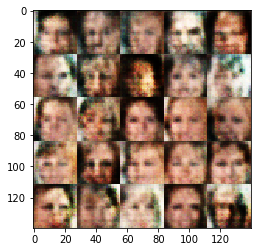

Epoch: 1/1 Discriminator Loss: 0.46756893396377563 Generator Loss: 1.607466697692871
Epoch: 1/1 Discriminator Loss: 0.5012291669845581 Generator Loss: 1.7115321159362793
Epoch: 1/1 Discriminator Loss: 0.5004798769950867 Generator Loss: 1.4032621383666992
Epoch: 1/1 Discriminator Loss: 0.6061112284660339 Generator Loss: 1.284540057182312
Epoch: 1/1 Discriminator Loss: 0.6427009701728821 Generator Loss: 1.5376811027526855
Epoch: 1/1 Discriminator Loss: 0.4880218505859375 Generator Loss: 2.407954692840576
Epoch: 1/1 Discriminator Loss: 0.5498476028442383 Generator Loss: 1.5013244152069092
Epoch: 1/1 Discriminator Loss: 0.4458722174167633 Generator Loss: 1.4642226696014404
Epoch: 1/1 Discriminator Loss: 0.7509475946426392 Generator Loss: 1.3139458894729614
Epoch: 1/1 Discriminator Loss: 0.6817296743392944 Generator Loss: 1.2144155502319336


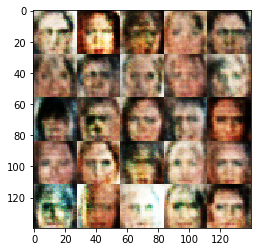

Epoch: 1/1 Discriminator Loss: 0.5943796038627625 Generator Loss: 1.1070847511291504
Epoch: 1/1 Discriminator Loss: 0.48719167709350586 Generator Loss: 1.5700358152389526
Epoch: 1/1 Discriminator Loss: 0.6892006397247314 Generator Loss: 1.7358977794647217
Epoch: 1/1 Discriminator Loss: 0.6358411312103271 Generator Loss: 1.6252098083496094
Epoch: 1/1 Discriminator Loss: 0.810917854309082 Generator Loss: 3.5625500679016113
Epoch: 1/1 Discriminator Loss: 0.5208180546760559 Generator Loss: 1.6448783874511719
Epoch: 1/1 Discriminator Loss: 0.6517024636268616 Generator Loss: 2.010626792907715
Epoch: 1/1 Discriminator Loss: 0.48806872963905334 Generator Loss: 1.7178900241851807
Epoch: 1/1 Discriminator Loss: 0.504408597946167 Generator Loss: 1.5750889778137207
Epoch: 1/1 Discriminator Loss: 0.41490721702575684 Generator Loss: 2.666256904602051


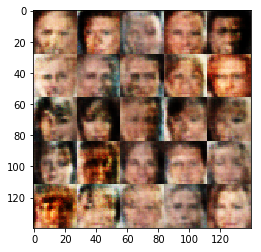

Epoch: 1/1 Discriminator Loss: 0.6369826793670654 Generator Loss: 1.226585865020752
Epoch: 1/1 Discriminator Loss: 0.3103967308998108 Generator Loss: 2.15684175491333
Epoch: 1/1 Discriminator Loss: 0.7737753391265869 Generator Loss: 1.0512956380844116
Epoch: 1/1 Discriminator Loss: 0.731951117515564 Generator Loss: 1.6862740516662598
Epoch: 1/1 Discriminator Loss: 0.7283934354782104 Generator Loss: 1.452377200126648
Epoch: 1/1 Discriminator Loss: 0.720396101474762 Generator Loss: 1.2825706005096436
Epoch: 1/1 Discriminator Loss: 0.5384959578514099 Generator Loss: 1.6970984935760498
Epoch: 1/1 Discriminator Loss: 0.5763818025588989 Generator Loss: 1.6386277675628662
Epoch: 1/1 Discriminator Loss: 0.5947761535644531 Generator Loss: 2.4968531131744385
Epoch: 1/1 Discriminator Loss: 0.6817864179611206 Generator Loss: 1.0306521654129028


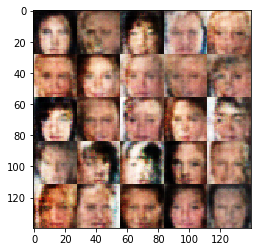

Epoch: 1/1 Discriminator Loss: 0.6258270144462585 Generator Loss: 1.5259103775024414
Epoch: 1/1 Discriminator Loss: 0.5874549150466919 Generator Loss: 2.1271543502807617
Epoch: 1/1 Discriminator Loss: 0.5401147603988647 Generator Loss: 1.5187478065490723
Epoch: 1/1 Discriminator Loss: 0.6755623817443848 Generator Loss: 2.128505229949951
Epoch: 1/1 Discriminator Loss: 0.6463906168937683 Generator Loss: 1.0695359706878662
Epoch: 1/1 Discriminator Loss: 0.6619999408721924 Generator Loss: 1.980974793434143
Epoch: 1/1 Discriminator Loss: 0.6357262134552002 Generator Loss: 1.3389067649841309
Epoch: 1/1 Discriminator Loss: 0.6602029204368591 Generator Loss: 1.1424237489700317
Epoch: 1/1 Discriminator Loss: 0.5428687334060669 Generator Loss: 1.7962032556533813
Epoch: 1/1 Discriminator Loss: 0.6466015577316284 Generator Loss: 1.273071527481079


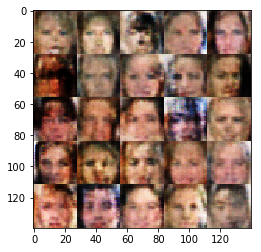

Epoch: 1/1 Discriminator Loss: 1.1422300338745117 Generator Loss: 0.5498977303504944
Epoch: 1/1 Discriminator Loss: 0.6388149261474609 Generator Loss: 1.1831767559051514
Epoch: 1/1 Discriminator Loss: 0.722378134727478 Generator Loss: 2.1270358562469482
Epoch: 1/1 Discriminator Loss: 0.7364863157272339 Generator Loss: 1.0210137367248535
Epoch: 1/1 Discriminator Loss: 1.0163873434066772 Generator Loss: 0.6365214586257935
Epoch: 1/1 Discriminator Loss: 0.6371970176696777 Generator Loss: 1.1152598857879639
Epoch: 1/1 Discriminator Loss: 0.6995067596435547 Generator Loss: 1.1230499744415283
Epoch: 1/1 Discriminator Loss: 0.8404170274734497 Generator Loss: 0.7436919212341309
Epoch: 1/1 Discriminator Loss: 0.5403546094894409 Generator Loss: 1.6006996631622314
Epoch: 1/1 Discriminator Loss: 0.6195719242095947 Generator Loss: 1.282517671585083


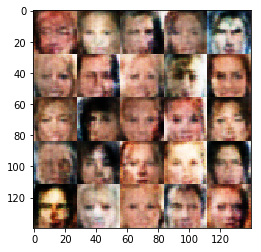

Epoch: 1/1 Discriminator Loss: 0.7240382432937622 Generator Loss: 1.726219892501831
Epoch: 1/1 Discriminator Loss: 0.7139145135879517 Generator Loss: 1.1633999347686768
Epoch: 1/1 Discriminator Loss: 0.7578051090240479 Generator Loss: 0.9881824851036072
Epoch: 1/1 Discriminator Loss: 0.592445969581604 Generator Loss: 1.3836207389831543
Epoch: 1/1 Discriminator Loss: 0.6050761938095093 Generator Loss: 1.6409456729888916
Epoch: 1/1 Discriminator Loss: 0.9028182029724121 Generator Loss: 2.877720355987549
Epoch: 1/1 Discriminator Loss: 0.5035412311553955 Generator Loss: 1.5931700468063354
Epoch: 1/1 Discriminator Loss: 0.8626890182495117 Generator Loss: 0.7941629886627197
Epoch: 1/1 Discriminator Loss: 0.5405872464179993 Generator Loss: 1.8947821855545044
Epoch: 1/1 Discriminator Loss: 0.6723218560218811 Generator Loss: 1.673569917678833


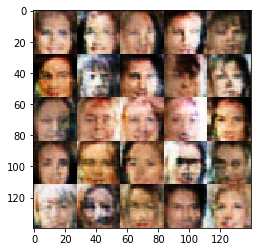

Epoch: 1/1 Discriminator Loss: 0.6506302952766418 Generator Loss: 1.1507189273834229
Epoch: 1/1 Discriminator Loss: 0.7267364859580994 Generator Loss: 1.1182527542114258
Epoch: 1/1 Discriminator Loss: 0.7659903764724731 Generator Loss: 0.9322302341461182
Epoch: 1/1 Discriminator Loss: 0.6328999996185303 Generator Loss: 1.3502545356750488
Epoch: 1/1 Discriminator Loss: 0.5601497888565063 Generator Loss: 1.5212204456329346
Epoch: 1/1 Discriminator Loss: 0.5716323256492615 Generator Loss: 1.5329480171203613
Epoch: 1/1 Discriminator Loss: 0.5913068056106567 Generator Loss: 1.3542128801345825
Epoch: 1/1 Discriminator Loss: 0.6665533185005188 Generator Loss: 1.2480475902557373
Epoch: 1/1 Discriminator Loss: 0.7421221137046814 Generator Loss: 1.9364515542984009
Epoch: 1/1 Discriminator Loss: 0.6338819861412048 Generator Loss: 1.6214534044265747


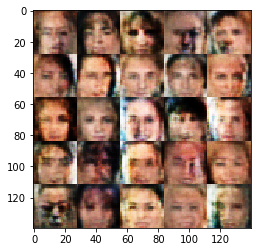

Epoch: 1/1 Discriminator Loss: 0.7004156112670898 Generator Loss: 1.0482065677642822
Epoch: 1/1 Discriminator Loss: 0.6433511972427368 Generator Loss: 1.6275995969772339
Epoch: 1/1 Discriminator Loss: 0.5519782900810242 Generator Loss: 1.595936894416809
Epoch: 1/1 Discriminator Loss: 0.6549402475357056 Generator Loss: 1.680663824081421
Epoch: 1/1 Discriminator Loss: 0.6399211883544922 Generator Loss: 1.0769679546356201
Epoch: 1/1 Discriminator Loss: 0.5372947454452515 Generator Loss: 1.9023997783660889
Epoch: 1/1 Discriminator Loss: 0.7726433277130127 Generator Loss: 2.714813709259033
Epoch: 1/1 Discriminator Loss: 0.680482804775238 Generator Loss: 1.1329872608184814
Epoch: 1/1 Discriminator Loss: 0.73284512758255 Generator Loss: 1.0343968868255615
Epoch: 1/1 Discriminator Loss: 0.7272466421127319 Generator Loss: 1.2086973190307617


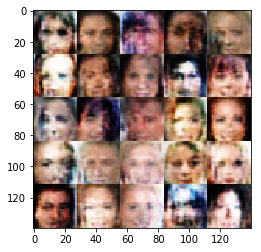

Epoch: 1/1 Discriminator Loss: 0.6998864412307739 Generator Loss: 2.4053640365600586
Epoch: 1/1 Discriminator Loss: 0.5459740161895752 Generator Loss: 1.5950520038604736
Epoch: 1/1 Discriminator Loss: 0.5659536123275757 Generator Loss: 1.284627079963684
Epoch: 1/1 Discriminator Loss: 0.5748081803321838 Generator Loss: 1.2099792957305908
Epoch: 1/1 Discriminator Loss: 0.7430349588394165 Generator Loss: 0.9793140888214111
Epoch: 1/1 Discriminator Loss: 0.7044707536697388 Generator Loss: 1.0719146728515625
Epoch: 1/1 Discriminator Loss: 0.8575314283370972 Generator Loss: 0.8041274547576904
Epoch: 1/1 Discriminator Loss: 0.9642268419265747 Generator Loss: 0.7838424444198608
Epoch: 1/1 Discriminator Loss: 0.5608993172645569 Generator Loss: 1.3602510690689087
Epoch: 1/1 Discriminator Loss: 0.8042328357696533 Generator Loss: 0.875550389289856


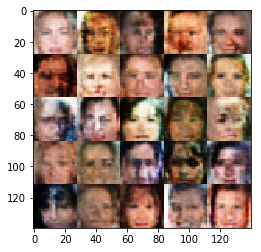

Epoch: 1/1 Discriminator Loss: 0.7068315744400024 Generator Loss: 1.305196762084961
Epoch: 1/1 Discriminator Loss: 0.7213327884674072 Generator Loss: 1.0795838832855225
Epoch: 1/1 Discriminator Loss: 0.7037042379379272 Generator Loss: 0.9950338006019592
Epoch: 1/1 Discriminator Loss: 0.6350263953208923 Generator Loss: 1.6421934366226196
Epoch: 1/1 Discriminator Loss: 0.6175901889801025 Generator Loss: 2.3009843826293945
Epoch: 1/1 Discriminator Loss: 0.6441676020622253 Generator Loss: 1.2375547885894775
Epoch: 1/1 Discriminator Loss: 0.839120626449585 Generator Loss: 0.7845193147659302
Epoch: 1/1 Discriminator Loss: 0.6241481304168701 Generator Loss: 1.9485535621643066
Epoch: 1/1 Discriminator Loss: 0.7064669132232666 Generator Loss: 1.0948610305786133
Epoch: 1/1 Discriminator Loss: 0.5952497720718384 Generator Loss: 1.2966077327728271


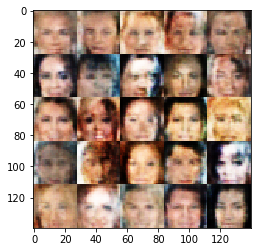

Epoch: 1/1 Discriminator Loss: 0.9396069645881653 Generator Loss: 0.75898277759552
Epoch: 1/1 Discriminator Loss: 0.6248338222503662 Generator Loss: 1.1458983421325684
Epoch: 1/1 Discriminator Loss: 0.5885648727416992 Generator Loss: 1.4704289436340332
Epoch: 1/1 Discriminator Loss: 0.6471474766731262 Generator Loss: 1.074703574180603
Epoch: 1/1 Discriminator Loss: 0.5684983730316162 Generator Loss: 1.6950660943984985
Epoch: 1/1 Discriminator Loss: 0.6206685304641724 Generator Loss: 1.2019538879394531
Epoch: 1/1 Discriminator Loss: 0.7130813598632812 Generator Loss: 1.2266733646392822
Epoch: 1/1 Discriminator Loss: 0.5147421360015869 Generator Loss: 1.8977564573287964
Epoch: 1/1 Discriminator Loss: 1.0156431198120117 Generator Loss: 0.7593003511428833
Epoch: 1/1 Discriminator Loss: 0.5366268157958984 Generator Loss: 1.392965316772461


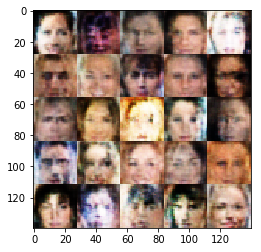

Epoch: 1/1 Discriminator Loss: 0.5644558668136597 Generator Loss: 1.7608506679534912
Epoch: 1/1 Discriminator Loss: 0.6881685256958008 Generator Loss: 1.0722739696502686
Epoch: 1/1 Discriminator Loss: 0.6552858948707581 Generator Loss: 1.1437039375305176
Epoch: 1/1 Discriminator Loss: 0.7548553347587585 Generator Loss: 1.8419955968856812
Epoch: 1/1 Discriminator Loss: 0.5005914568901062 Generator Loss: 1.4331157207489014
Epoch: 1/1 Discriminator Loss: 0.5748554468154907 Generator Loss: 1.3940281867980957
Epoch: 1/1 Discriminator Loss: 0.3987458348274231 Generator Loss: 1.8793330192565918
Epoch: 1/1 Discriminator Loss: 0.7542688250541687 Generator Loss: 0.9371699690818787
Epoch: 1/1 Discriminator Loss: 0.5224931240081787 Generator Loss: 1.6157279014587402
Epoch: 1/1 Discriminator Loss: 0.7053948640823364 Generator Loss: 1.1125519275665283


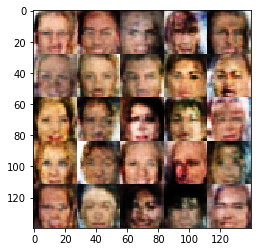

Epoch: 1/1 Discriminator Loss: 0.6148545742034912 Generator Loss: 1.703091025352478
Epoch: 1/1 Discriminator Loss: 0.6378811597824097 Generator Loss: 1.2782902717590332
Epoch: 1/1 Discriminator Loss: 0.5205836892127991 Generator Loss: 1.9508326053619385
Epoch: 1/1 Discriminator Loss: 0.8260242342948914 Generator Loss: 1.0679457187652588
Epoch: 1/1 Discriminator Loss: 0.768822431564331 Generator Loss: 0.9999057054519653
Epoch: 1/1 Discriminator Loss: 0.640079915523529 Generator Loss: 1.1844258308410645
Epoch: 1/1 Discriminator Loss: 0.92113196849823 Generator Loss: 0.6746377944946289
Epoch: 1/1 Discriminator Loss: 0.6897095441818237 Generator Loss: 1.096771240234375
Epoch: 1/1 Discriminator Loss: 0.7951048612594604 Generator Loss: 3.0575504302978516
Epoch: 1/1 Discriminator Loss: 0.5301384329795837 Generator Loss: 3.4832262992858887


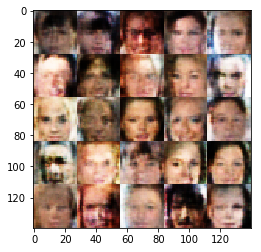

Epoch: 1/1 Discriminator Loss: 0.809249222278595 Generator Loss: 1.4397377967834473
Epoch: 1/1 Discriminator Loss: 0.8932104110717773 Generator Loss: 0.7842203974723816
Epoch: 1/1 Discriminator Loss: 0.5320440530776978 Generator Loss: 1.9585797786712646
Epoch: 1/1 Discriminator Loss: 0.7155370712280273 Generator Loss: 1.0973131656646729
Epoch: 1/1 Discriminator Loss: 0.5392042398452759 Generator Loss: 1.4362356662750244
Epoch: 1/1 Discriminator Loss: 0.4100159704685211 Generator Loss: 1.8309136629104614
Epoch: 1/1 Discriminator Loss: 0.7020921111106873 Generator Loss: 1.8344578742980957
Epoch: 1/1 Discriminator Loss: 0.5275923013687134 Generator Loss: 1.6523404121398926
Epoch: 1/1 Discriminator Loss: 0.5618438124656677 Generator Loss: 1.8626303672790527
Epoch: 1/1 Discriminator Loss: 0.48770397901535034 Generator Loss: 1.7788584232330322


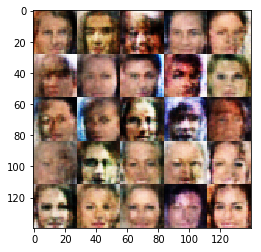

Epoch: 1/1 Discriminator Loss: 0.5182260274887085 Generator Loss: 1.7867534160614014
Epoch: 1/1 Discriminator Loss: 0.6343827247619629 Generator Loss: 1.4400110244750977
Epoch: 1/1 Discriminator Loss: 0.5880414247512817 Generator Loss: 2.2972264289855957
Epoch: 1/1 Discriminator Loss: 0.42115074396133423 Generator Loss: 1.92026686668396
Epoch: 1/1 Discriminator Loss: 0.7824777364730835 Generator Loss: 1.4013046026229858
Epoch: 1/1 Discriminator Loss: 0.648685097694397 Generator Loss: 1.5855622291564941
Epoch: 1/1 Discriminator Loss: 0.7148162126541138 Generator Loss: 1.0692237615585327
Epoch: 1/1 Discriminator Loss: 0.44290128350257874 Generator Loss: 1.885294795036316
Epoch: 1/1 Discriminator Loss: 0.5552213191986084 Generator Loss: 1.6764256954193115
Epoch: 1/1 Discriminator Loss: 0.6747735738754272 Generator Loss: 1.2086315155029297


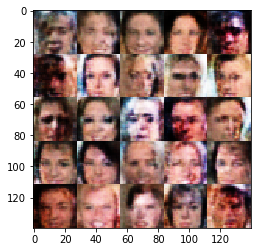

Epoch: 1/1 Discriminator Loss: 0.5278992652893066 Generator Loss: 1.58070969581604
Epoch: 1/1 Discriminator Loss: 0.670205295085907 Generator Loss: 1.1036174297332764
Epoch: 1/1 Discriminator Loss: 0.30219343304634094 Generator Loss: 2.3059134483337402
Epoch: 1/1 Discriminator Loss: 0.7319755554199219 Generator Loss: 2.2890920639038086
Epoch: 1/1 Discriminator Loss: 0.8359919786453247 Generator Loss: 0.8876504302024841
Epoch: 1/1 Discriminator Loss: 0.8551738262176514 Generator Loss: 2.601788282394409
Epoch: 1/1 Discriminator Loss: 0.5519863367080688 Generator Loss: 1.5079597234725952
Epoch: 1/1 Discriminator Loss: 0.5752083659172058 Generator Loss: 1.6097149848937988
Epoch: 1/1 Discriminator Loss: 0.6027827262878418 Generator Loss: 1.5367579460144043
Epoch: 1/1 Discriminator Loss: 0.7444323301315308 Generator Loss: 1.043025016784668


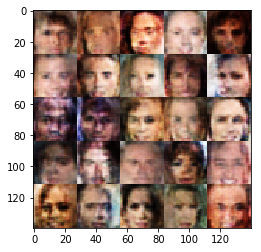

Epoch: 1/1 Discriminator Loss: 0.5140367150306702 Generator Loss: 1.3748459815979004
Epoch: 1/1 Discriminator Loss: 0.5951822996139526 Generator Loss: 1.3799960613250732
Epoch: 1/1 Discriminator Loss: 0.6349671483039856 Generator Loss: 1.2195454835891724
Epoch: 1/1 Discriminator Loss: 0.6403672695159912 Generator Loss: 1.169271469116211


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

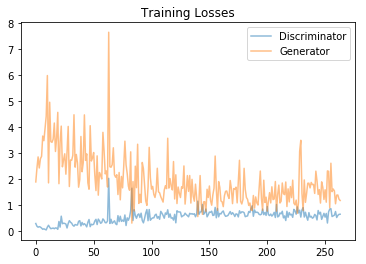

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.